In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
#import loompy
import matplotlib as mpl
import harmonypy as hm

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.settings.set_figure_params(dpi=80, color_map='viridis')
#sc.logging.print_versions()

In [2]:
input_file = '/lustre/scratch117/cellgen/team205/rl20/CTCL/object-new/Bcell_sanger_Vienna.h5ad'
adata = sc.read_h5ad(input_file)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


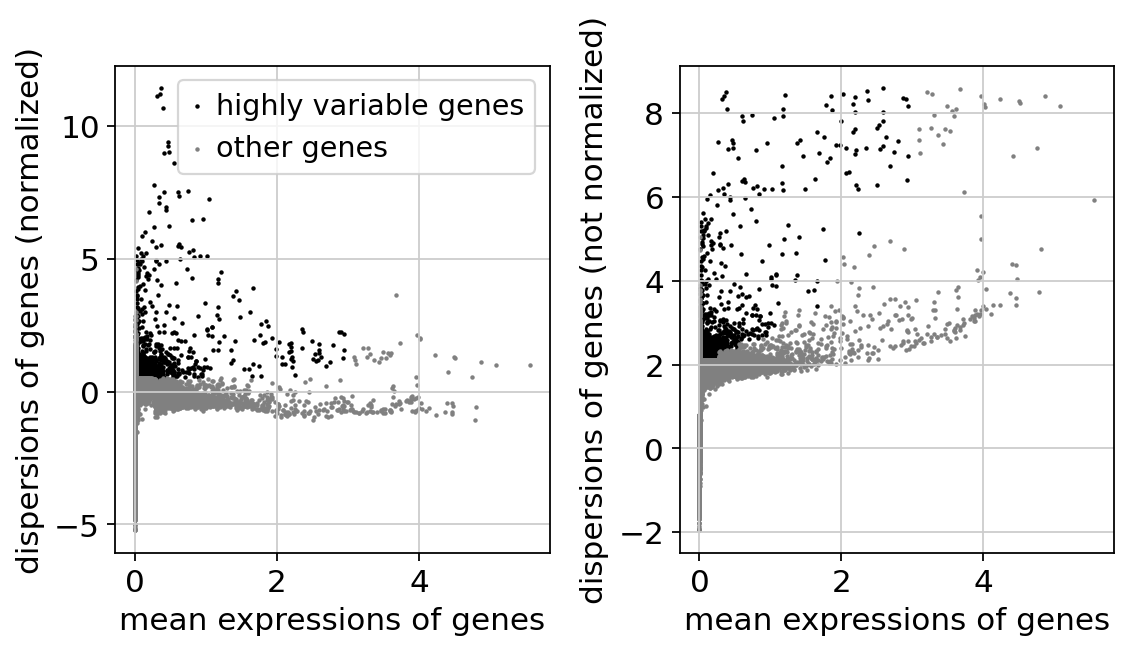

In [48]:
adata.raw = adata
sc.settings.set_figure_params(dpi=80, facecolor='white')
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [49]:
adata.var['highly_variable'].value_counts()

False    31254
True      2284
Name: highly_variable, dtype: int64

In [50]:
### remove IGgenes from HVG
import re
for i in adata.var.index:
    if re.search('^IG[HKL][VDJC]', i):
        adata.var.at[i, 'highly_variable'] = False

In [51]:
adata.var['highly_variable'].value_counts()

False    31396
True      2142
Name: highly_variable, dtype: int64

In [52]:
adata_filtered = adata[:, adata.var['highly_variable']]

In [53]:
sc.pp.regress_out(adata_filtered, ['percent_mito'])

regressing out ['percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:01:35)


In [54]:
sc.pp.scale(adata_filtered, max_value=10)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:04)


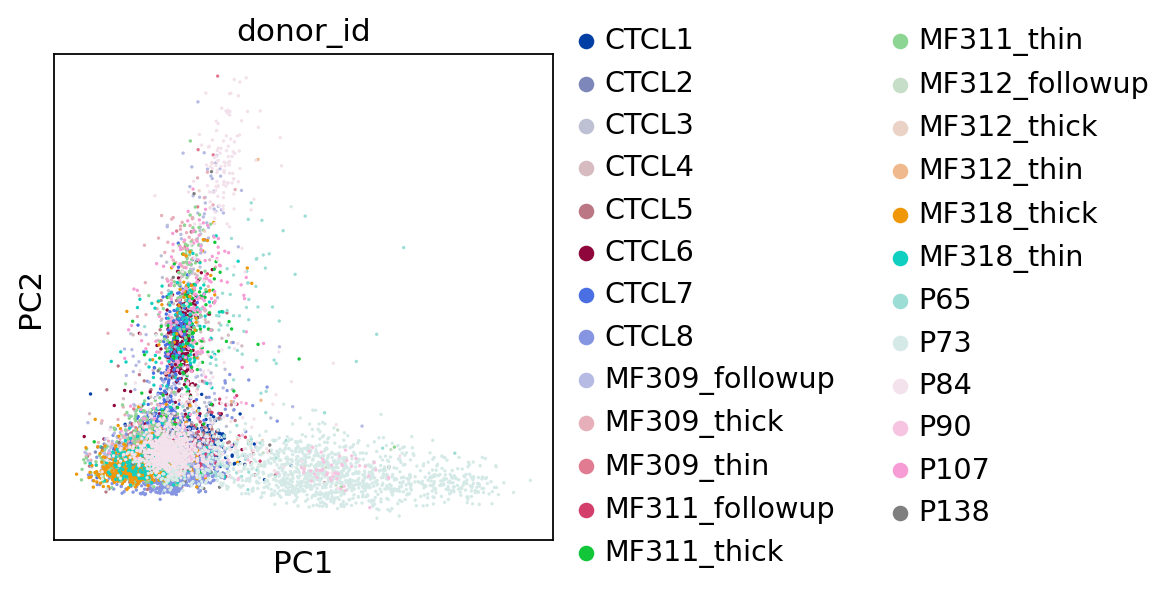

In [55]:
sc.tl.pca(adata_filtered, n_comps=50)
sc.pl.pca(adata_filtered, color = ['donor_id'])

In [56]:
adata_filtered_harmony = adata_filtered.copy()

In [57]:
#Set harmony variables
pca = np.array(adata_filtered_harmony.obsm["X_pca"])
batch = adata_filtered_harmony.obs['donor_id']
meta_data = adata_filtered_harmony.obs

#Run Harmony
ho = hm.run_harmony(pca, meta_data, ['donor_id'], theta = 3, random_state = 1234)
res = (pd.DataFrame(ho.Z_corr)).T
res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]

#Insert coordinates back into object
adata_filtered_harmony.obsm["X_pca_back"]= adata_filtered_harmony.obsm["X_pca"][:]
adata_filtered_harmony.obsm["X_pca"] = np.array(res)

2022-03-18 16:26:51,906 - harmonypy - INFO - Iteration 1 of 10
2022-03-18 16:27:02,806 - harmonypy - INFO - Iteration 2 of 10
2022-03-18 16:27:14,703 - harmonypy - INFO - Iteration 3 of 10
2022-03-18 16:27:26,425 - harmonypy - INFO - Iteration 4 of 10
2022-03-18 16:27:34,725 - harmonypy - INFO - Iteration 5 of 10
2022-03-18 16:27:44,499 - harmonypy - INFO - Iteration 6 of 10
2022-03-18 16:27:54,417 - harmonypy - INFO - Iteration 7 of 10
2022-03-18 16:28:04,628 - harmonypy - INFO - Converged after 7 iterations


In [58]:
sc.pp.neighbors(adata_filtered_harmony, n_neighbors=15, n_pcs=50, random_state = 1234)
sc.tl.umap(adata_filtered_harmony)

computing neighbors
    using 'X_pca' with n_pcs = 50


/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/numba/core/typed_passes.py:327: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../my-conda-envs/myenv_old/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP


/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


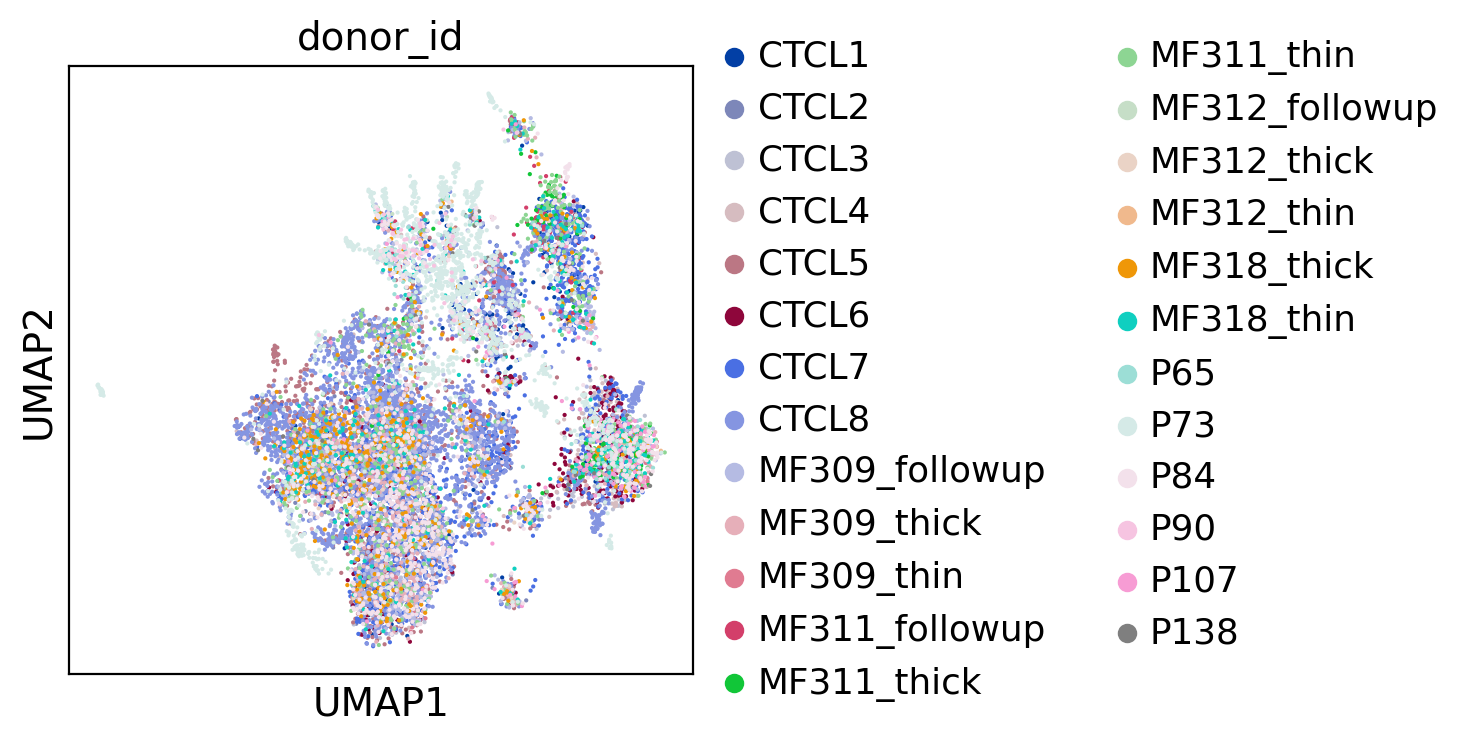

In [3]:
sc.settings.set_figure_params(dpi=100, facecolor='white')
sc.pl.umap(adata_filtered_harmony, color=['donor_id'])

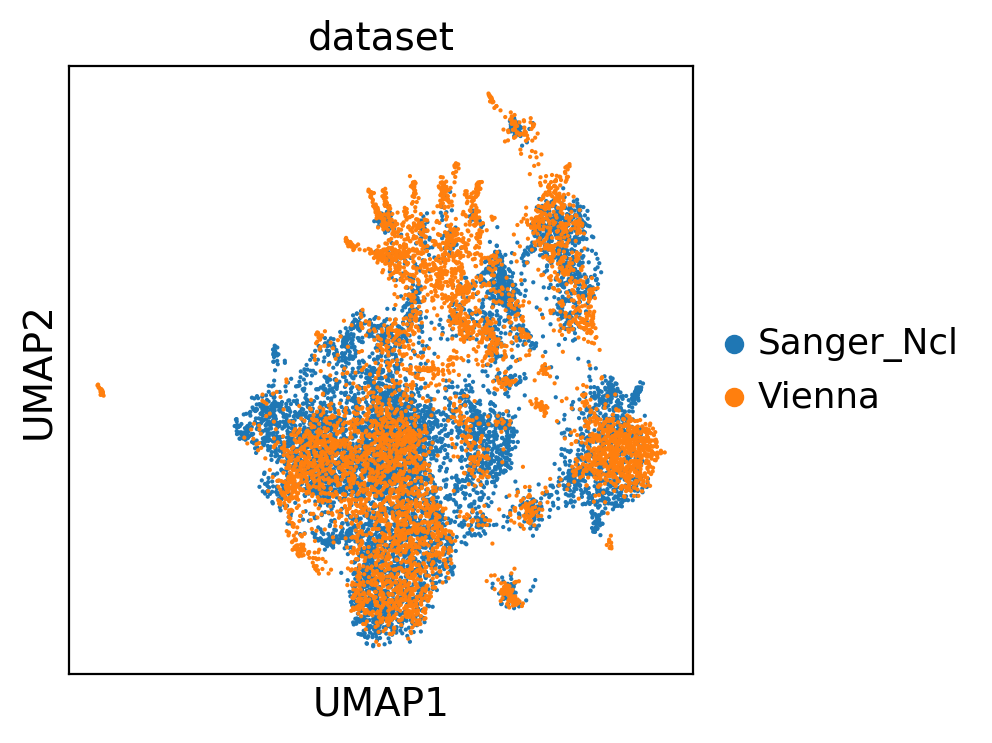

In [4]:
sc.settings.set_figure_params(dpi=100, facecolor='white')
sc.pl.umap(adata_filtered_harmony, color=['dataset'])

In [34]:
sc.tl.leiden(adata_filtered_harmony, resolution=0.8, key_added='leiden_0.8')

running Leiden clustering
    finished: found 22 clusters and added
    'leiden_0.8', the cluster labels (adata.obs, categorical) (0:00:01)


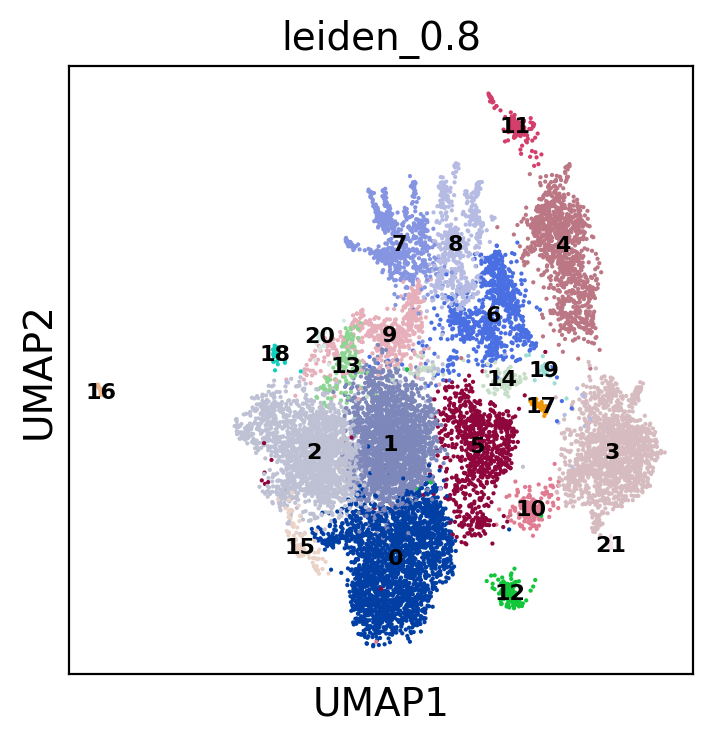

In [25]:
sc.settings.set_figure_params(dpi=100, facecolor='white')
sc.pl.umap(adata_filtered_harmony, color=['leiden_0.8'], legend_loc='on data',legend_fontsize=8)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:27)


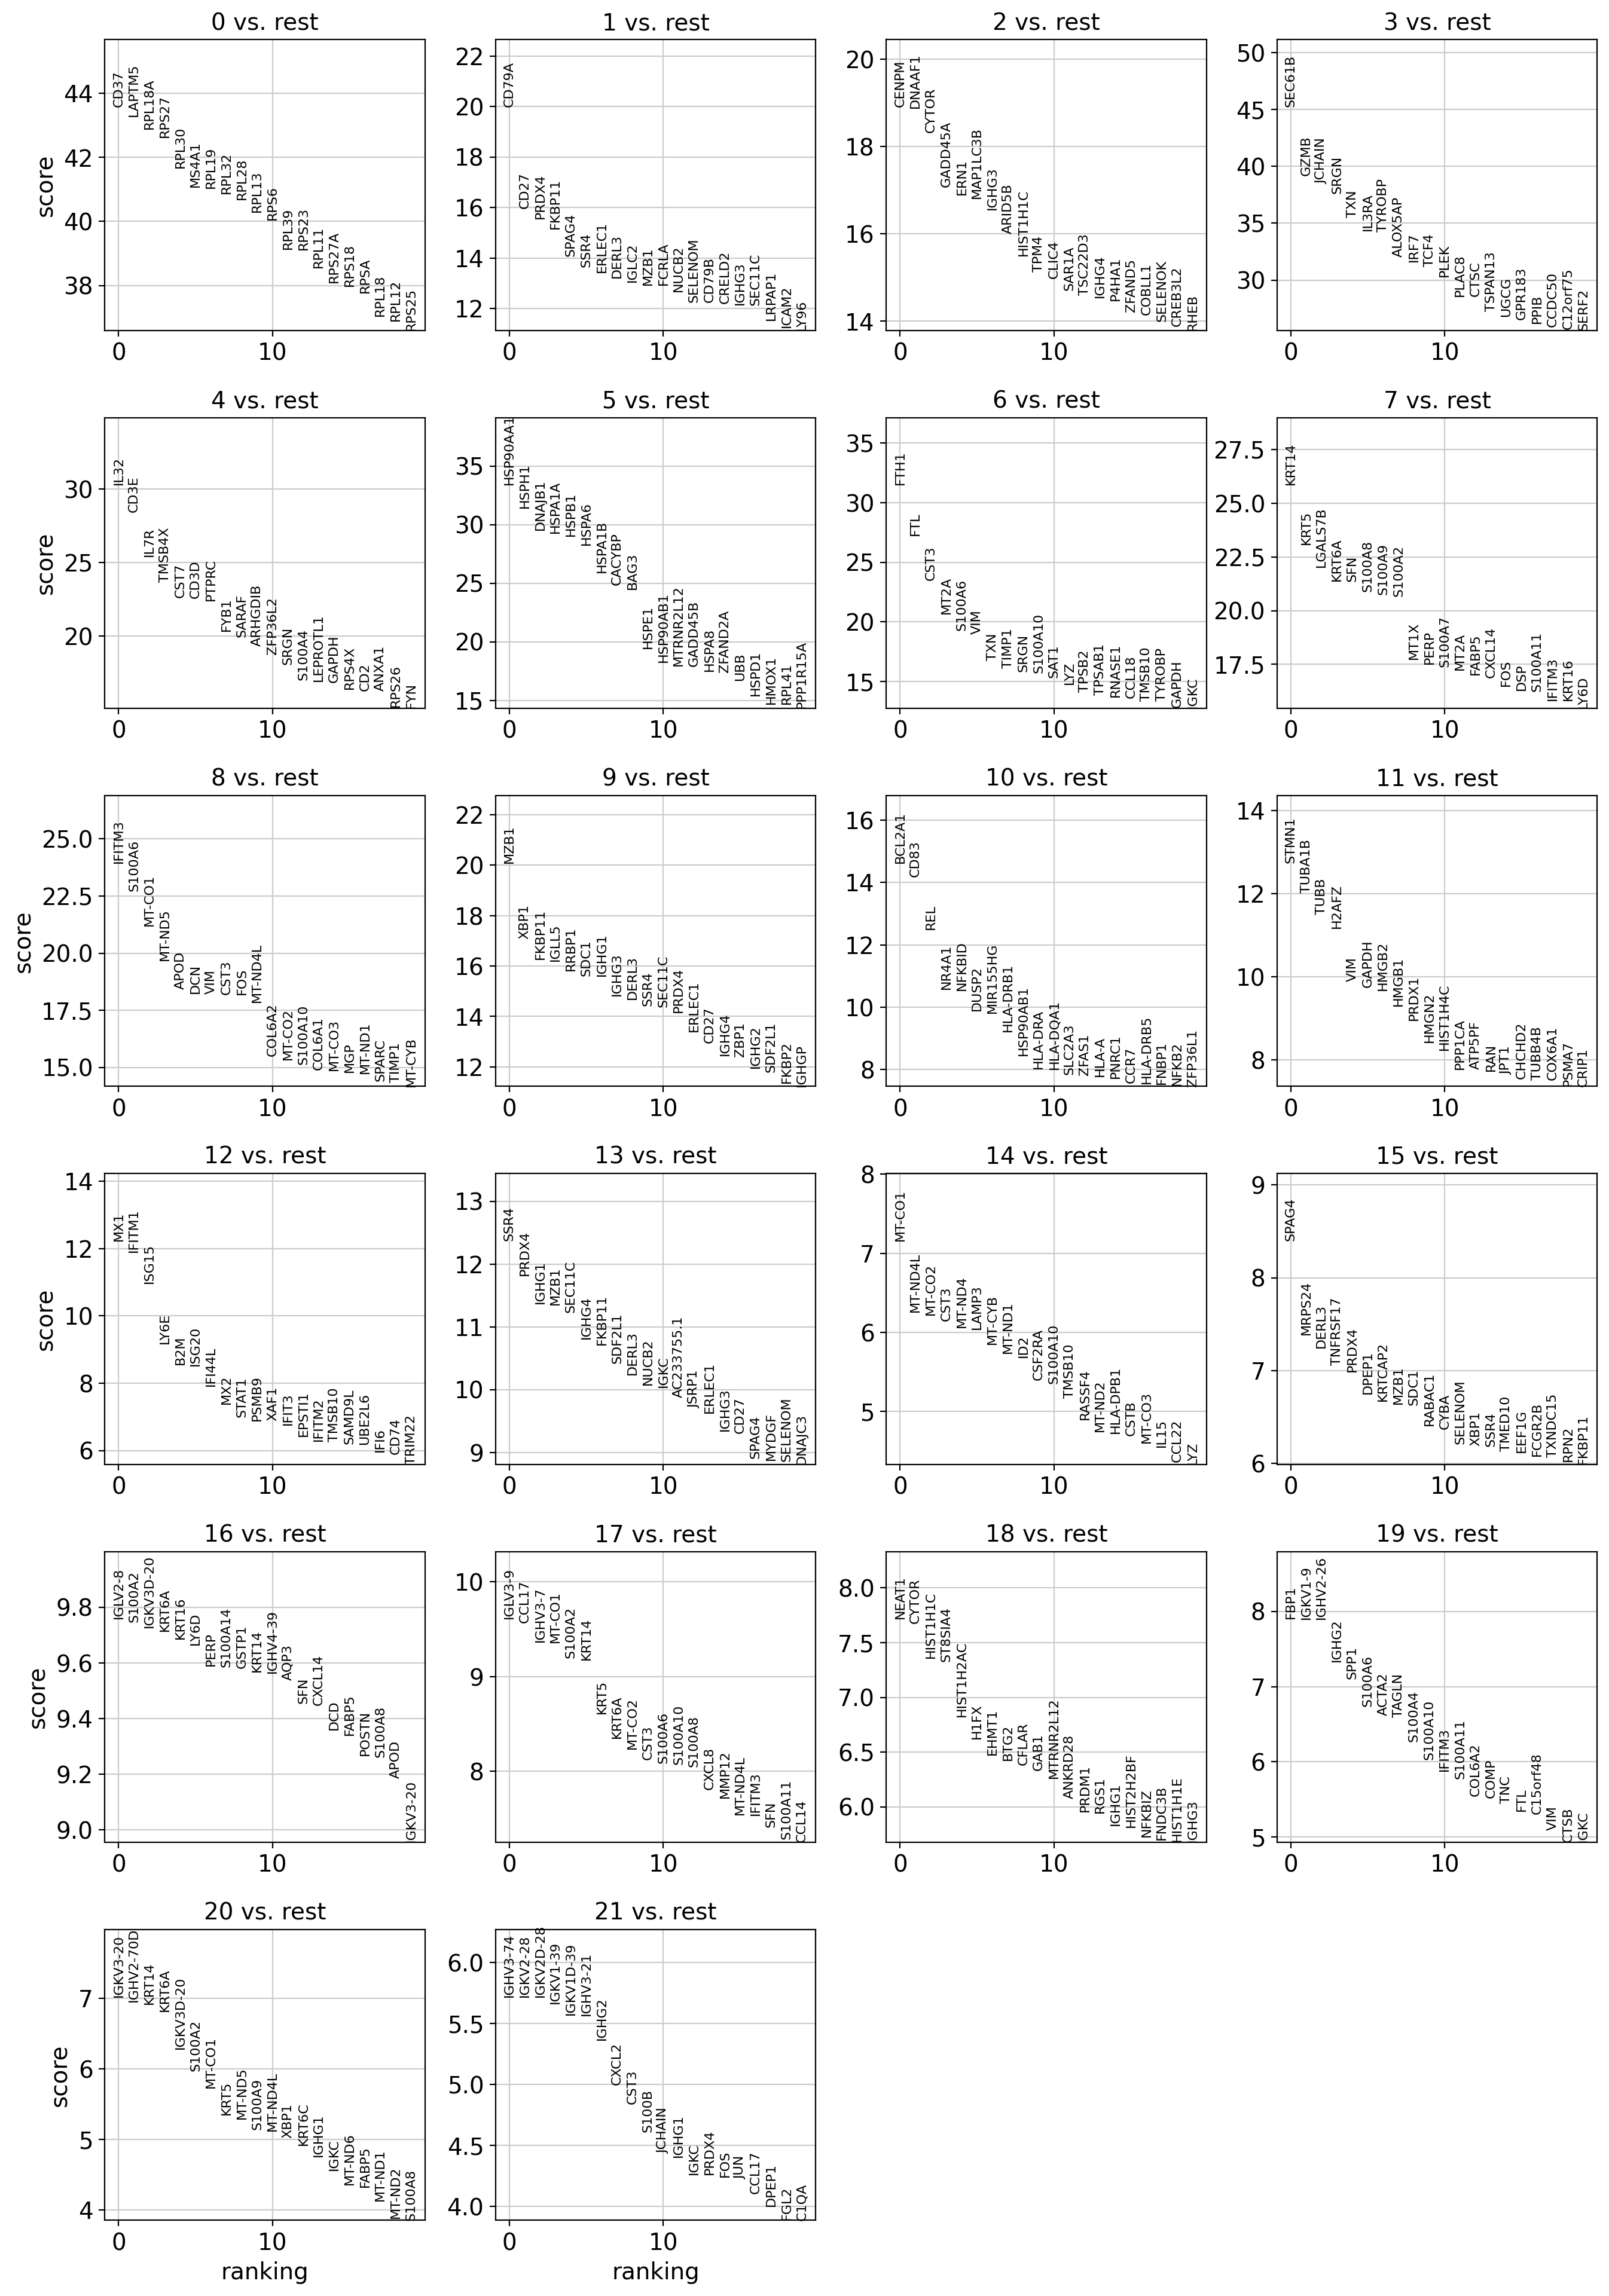

0_n  0_p       0_l     1_n           1_p       1_l       2_n  \
0    CD37  0.0  2.589335   CD79A  1.124784e-84  1.172090     CENPM   
1  LAPTM5  0.0  2.619388    CD27  4.891582e-54  1.060162    DNAAF1   
2  RPL18A  0.0  1.211199   PRDX4  2.323642e-51  1.171108     CYTOR   
3   RPS27  0.0  1.526785  FKBP11  9.786130e-49  1.177158   GADD45A   
4   RPL30  0.0  1.190835   SPAG4  8.550513e-42  1.045826      ERN1   
5   MS4A1  0.0  2.845257    SSR4  2.435888e-39  0.771273  MAP1LC3B   
6   RPL19  0.0  1.124426  ERLEC1  4.704620e-38  0.864330     IGHG3   
7   RPL32  0.0  1.160194   DERL3  6.078120e-37  1.046606    ARID5B   
8   RPL28  0.0  1.111372   IGLC2  6.145525e-36  1.630252  HIST1H1C   
9   RPL13  0.0  1.060964    MZB1  2.600936e-35  1.005360      TPM4   

            2_p       2_l      3_n  ...      18_l      19_n          19_p  \
0  2.900368e-75  3.222876   SEC61B  ...  5.625814      FBP1  3.306205e-11   
1  2.900368e-75  3.757465     GZMB  ...  5.595094   IGKV1-9  3.306205e-11   
2  5.902225e-71  2.117944   JCHAIN  ...  5.721403  IGHV2-26  3.306205e-11   
3  1.799994e-61  2.399624     SRGN  ...  5.377919     IGHG2  1.942143e-09   
4  3.390810e-60  1.936961      TXN  ...  4.832843      SPP1  8.091306e-09   
5  1.134380e-59  1.481191    IL3RA  ...  4.529771    S100A6  8.932585e-08   
6  6.137260e-58  1.618733   TYROBP  ...  4.293415     ACTA2  1.720819e-07   
7  3.573975e-54  1.123116  ALOX5AP  ...  4.062340     TAGLN  1.790640e-07   
8  7.769069e-51  1.783793     IRF7  ...  3.604592    S100A4  1.362264e-06   
9  2.080819e-48  1.252661     TCF4  ...  5.444083   S100A10  5.587031e-06   

        19_l       20_n          20_p       20_l       21_n      21_p  \
0   8.829245   IGKV3-20  5.266883e-08  10.818640   IGHV3-74  0.000121   
1  13.900112  IGHV2-70D  5.266883e-08  14.249442   IGKV2-28  0.000121   
2  14.630996      KRT14  5.266883e-08   5.228515  IGKV2D-28  0.000121   
3   6.546840      KRT6A  8.182650e-08   5.693615   IGKV1-39  0.000126   
4   8.429942  IGKV3D-20  2.228165e-06   6.689430  IGKV1D-39  0.000145   
5   3.445756     S100A2  1.178542e-05   5.132840   IGHV3-21  0.000145   
6   6.749757     MT-CO1  4.308119e-05   2.207922      IGHG2  0.000392   
7   6.720868       KRT5  3.298547e-04   4.289716      CXCL2  0.002468   
8   3.506129     MT-ND5  3.776310e-04   2.101475       CST3  0.004874   
9   3.043143     S100A9  6.716214e-04   4.670376      S100B  0.013602   

        21_l  
0  14.454183  
1  12.062263  
2  13.774650  
3  10.053589  
4   8.587481  
5  10.201991  
6   6.980117  
7   5.976908  
8   4.344276  
9   7.008694  

[10 rows x 66 columns]

In [26]:
sc.tl.rank_genes_groups(adata_filtered_harmony, 'leiden_0.8', method = 'wilcoxon', n_genes = 200, use_raw = True)
sc.pl.rank_genes_groups(adata_filtered_harmony, n_genes=20, sharey=False)
result = adata_filtered_harmony.uns['rank_genes_groups']
groups = result['names'].dtype.names
markers = pd.DataFrame(
{group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges']})
markers.head(10)

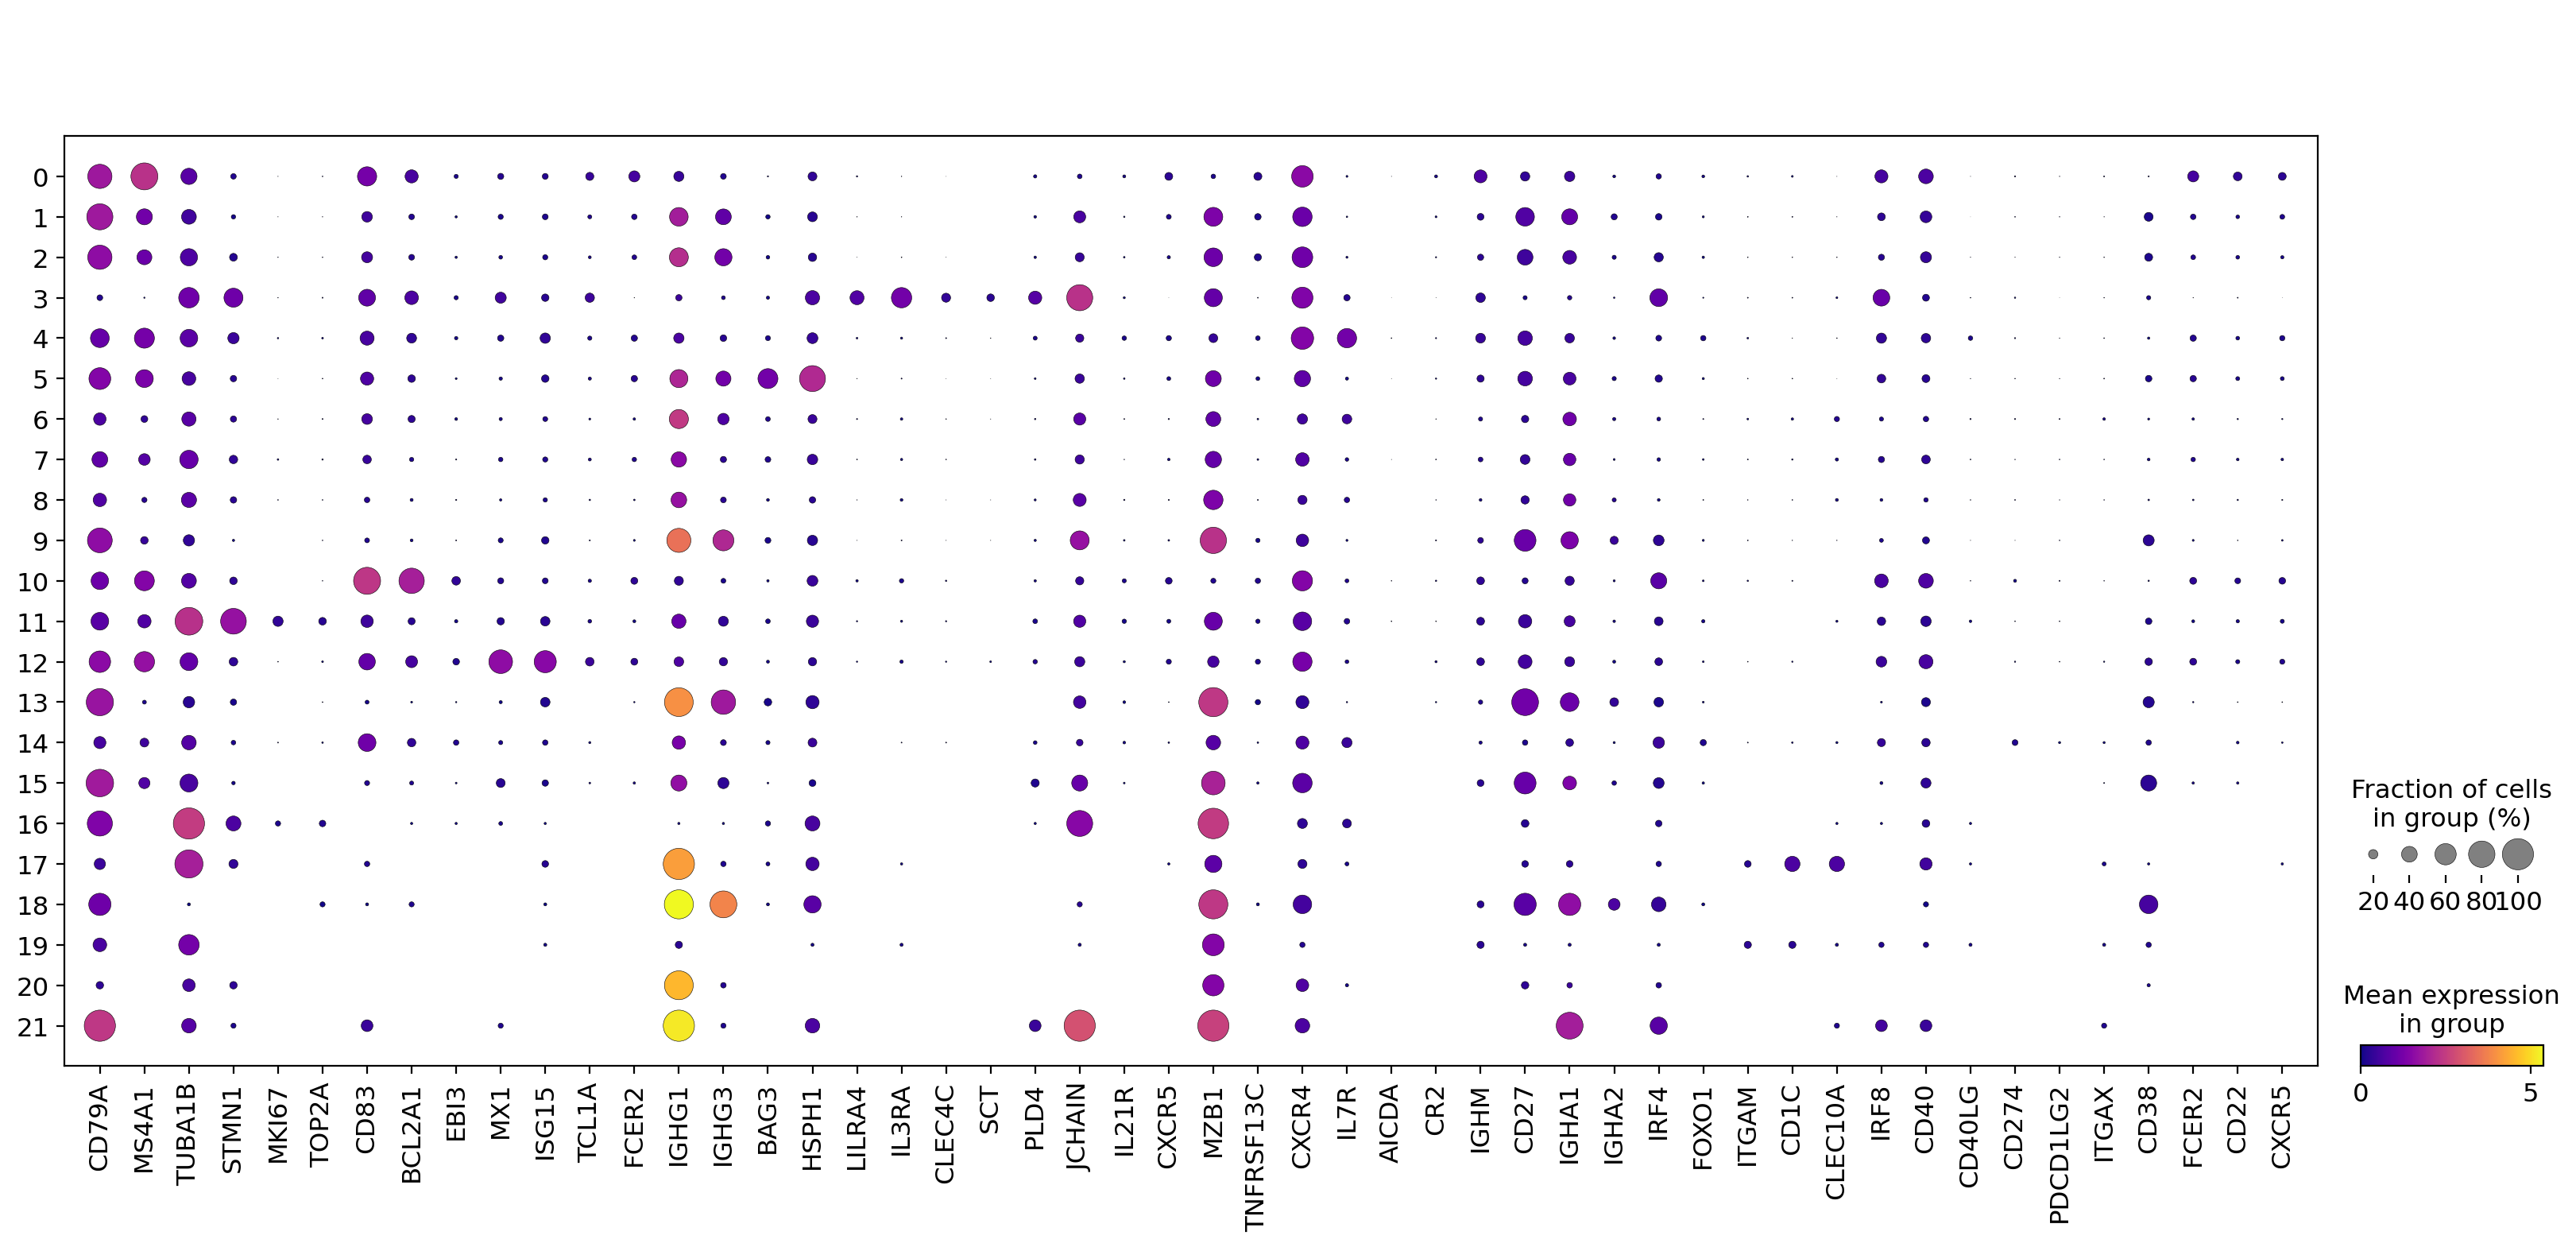

In [10]:
sc.settings.set_figure_params(dpi=100, facecolor='white')
genes = ['CD79A','MS4A1','TUBA1B','STMN1','MKI67','TOP2A','CD83','BCL2A1','EBI3',
         'MX1','ISG15','TCL1A','FCER2','IGHG1','IGHG3',
         'BAG3','HSPH1','LILRA4','IL3RA','CLEC4C','SCT','PLD4','JCHAIN',
         'IL21R','CXCR5','MZB1','TNFRSF13C','CXCR4','IL7R','AICDA','CR2','IGHM','CD27','IGHA1','IGHA2','IRF4','FOXO1',
         'ITGAM','CD1C','CLEC10A','IRF8','CD40','CD40LG','CD274','PDCD1LG2','ITGAX','CD38','FCER2','CD22','CXCR5']
#sc.tl.dendrogram(adata_filtered_harmony_sub, groupby='annotation')
dp = sc.pl.dotplot(adata_filtered_harmony, genes, groupby='leiden_0.8', use_raw=True, dendrogram=False, color_map='plasma')

In [7]:
mye_dict = {'0':'Naive_B',
            '1':'Plasma_IgG.1', 
            '2':'Plasma_IgG.2',
            '3':'pDC',
            '4':'Doublet',
            '5':'Plasma_IgG_Stress',
            '6':'Unclear',
            '7':'Doublet',
            '8':'Unclear',
            '9':'Plasma_IgG.1',
            '10':'GC-like_B',
            '11':'Cycling_B',
            '12':'IFN_response_B',
            '13':'Plasma_IgG.1',
            '14':'Unclear',
            '15':'Plasma_IgG.2',
            '16':'Doublet',
            '17':'Doublet',
            '18':'Plasma_IgG.2',
            '19':'Doublet',
            '20':'Doublet',
            '21':'Doublet'
           }

In [8]:
adata_filtered_harmony.obs['annotation'] = adata_filtered_harmony.obs['leiden_0.8'].map(mye_dict)

... storing 'annotation' as categorical


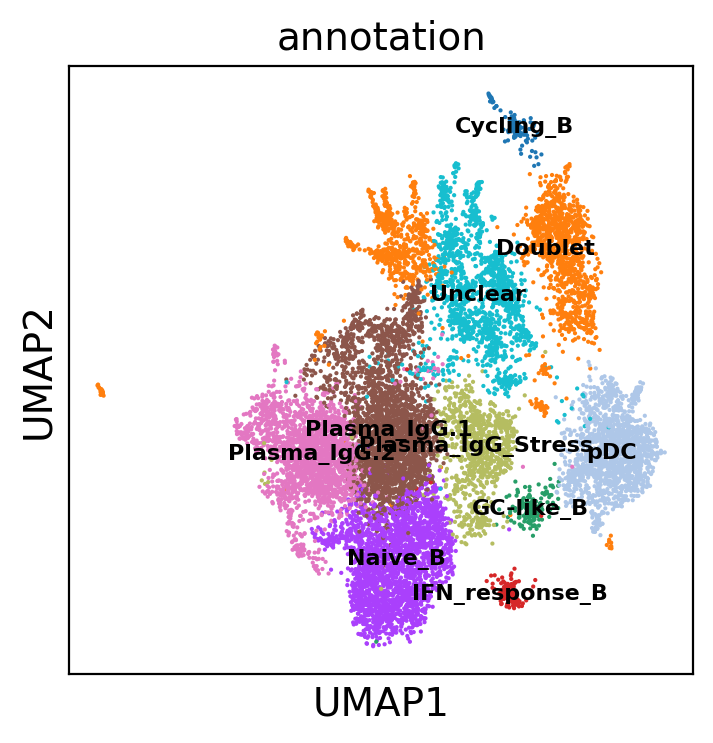

In [9]:
sc.settings.set_figure_params(dpi=100, facecolor='white')
sc.pl.umap(adata_filtered_harmony, color=['annotation'], legend_loc='on data',legend_fontsize=8)

In [17]:
def generate_colors(col_required):
    import random
    number_of_colors = col_required
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                 for i in range(number_of_colors)]
    return list(color)

In [24]:
col

['#4C92E4', '#E9DE53', '#A626F4', '#F97215', '#F4DBC5', '#BC11AA', '#74EB69']

Trying to set attribute `.uns` of view, copying.


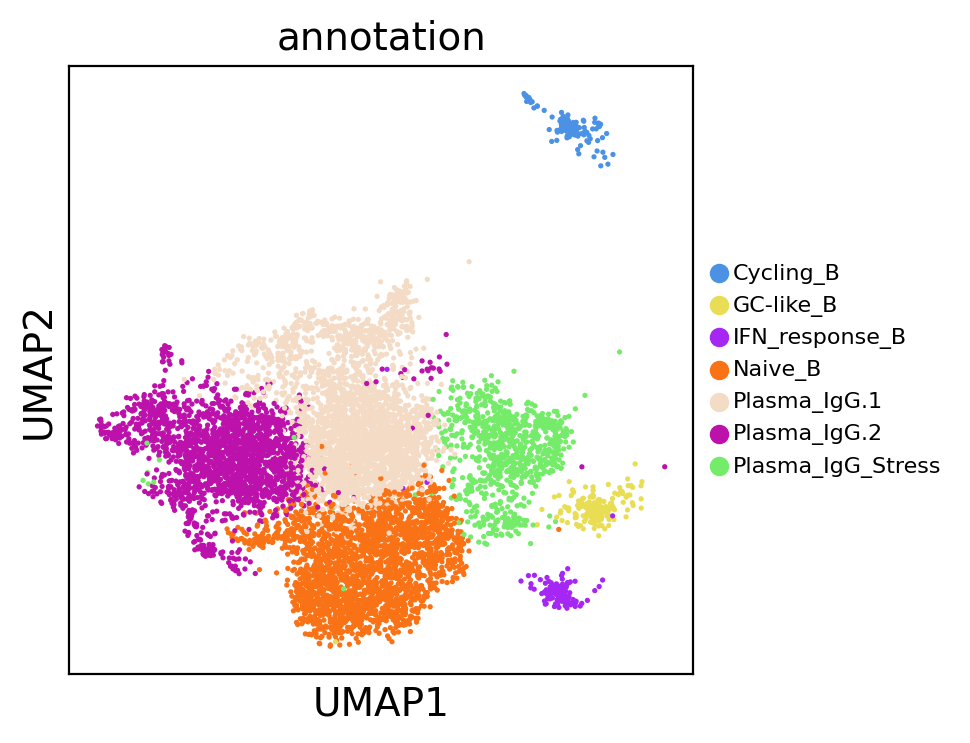

In [10]:
col=['#4C92E4', '#E9DE53', '#A626F4', '#F97215', '#F4DBC5', '#BC11AA', '#74EB69']
adata_filtered_harmony_sub = adata_filtered_harmony[~adata_filtered_harmony.obs['annotation'].isin(['Doublet','pDC','Unclear'])]
sc.pl.umap(adata_filtered_harmony_sub, color=['annotation'],legend_fontsize=8, palette = col)

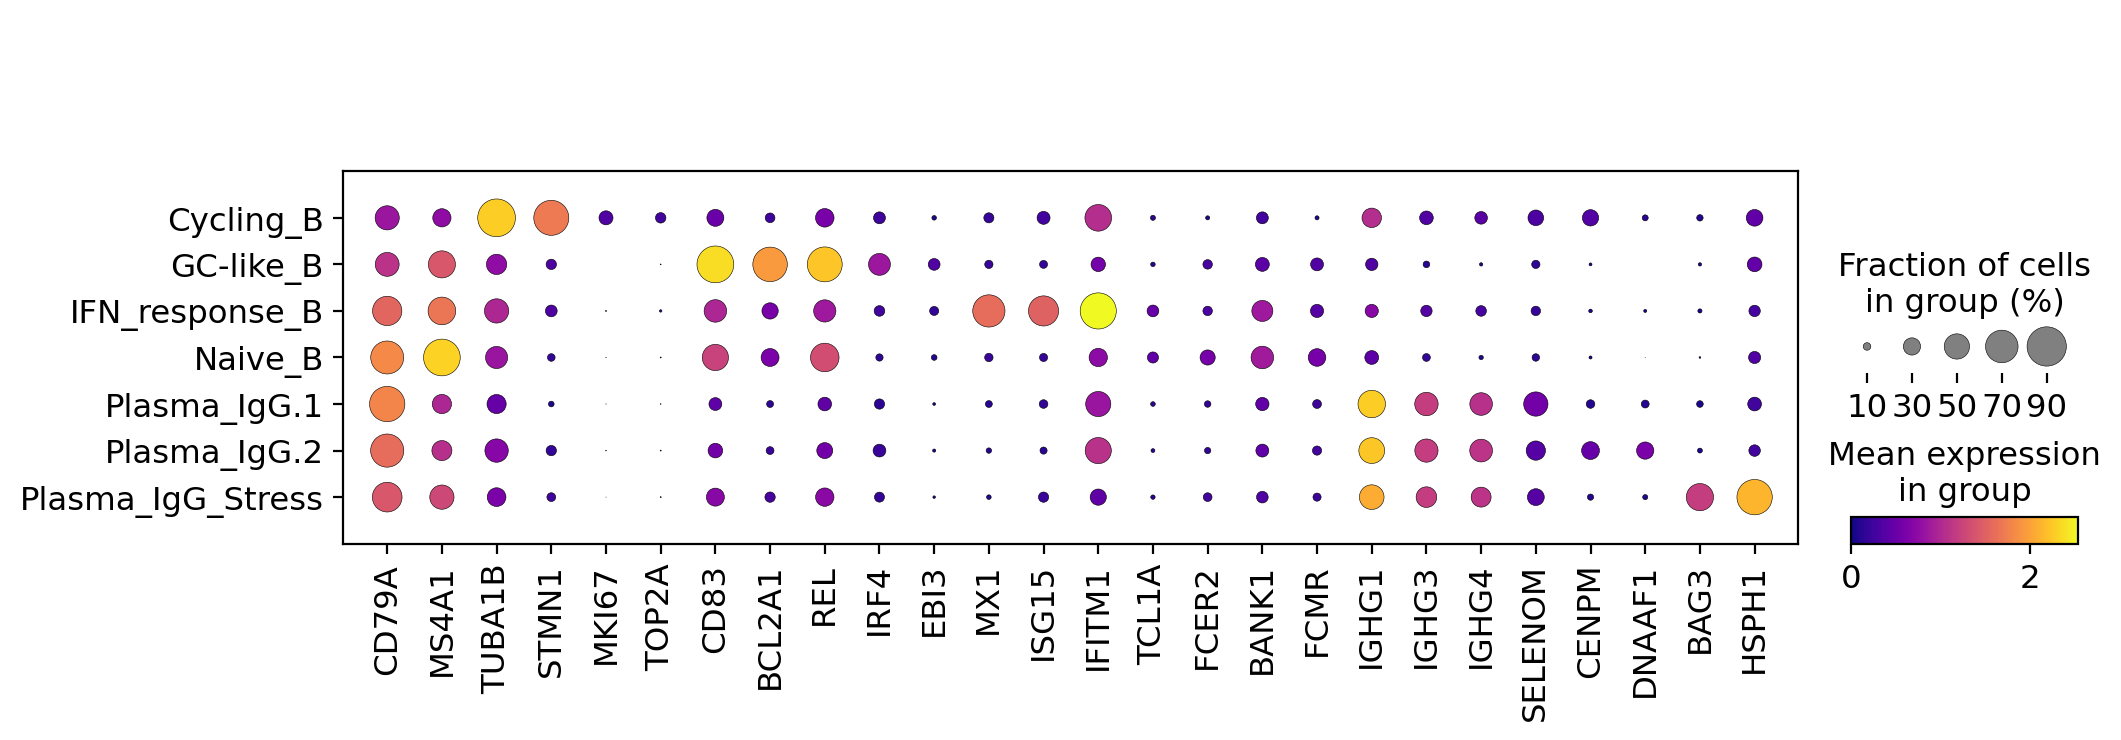

In [116]:
sc.settings.set_figure_params(dpi=100, facecolor='white')
genes = ['CD79A','MS4A1','TUBA1B','STMN1','MKI67','TOP2A','CD83','BCL2A1','REL','IRF4','EBI3',
         'MX1','ISG15','IFITM1','TCL1A','FCER2','BANK1','FCMR','IGHG1','IGHG3','IGHG4','SELENOM',
         'CENPM','DNAAF1','BAG3','HSPH1']
#sc.tl.dendrogram(adata_filtered_harmony_sub, groupby='annotation')
dp = sc.pl.dotplot(adata_filtered_harmony_sub, genes, groupby='annotation', use_raw=True, dendrogram=False, color_map='plasma',save='.pdf')

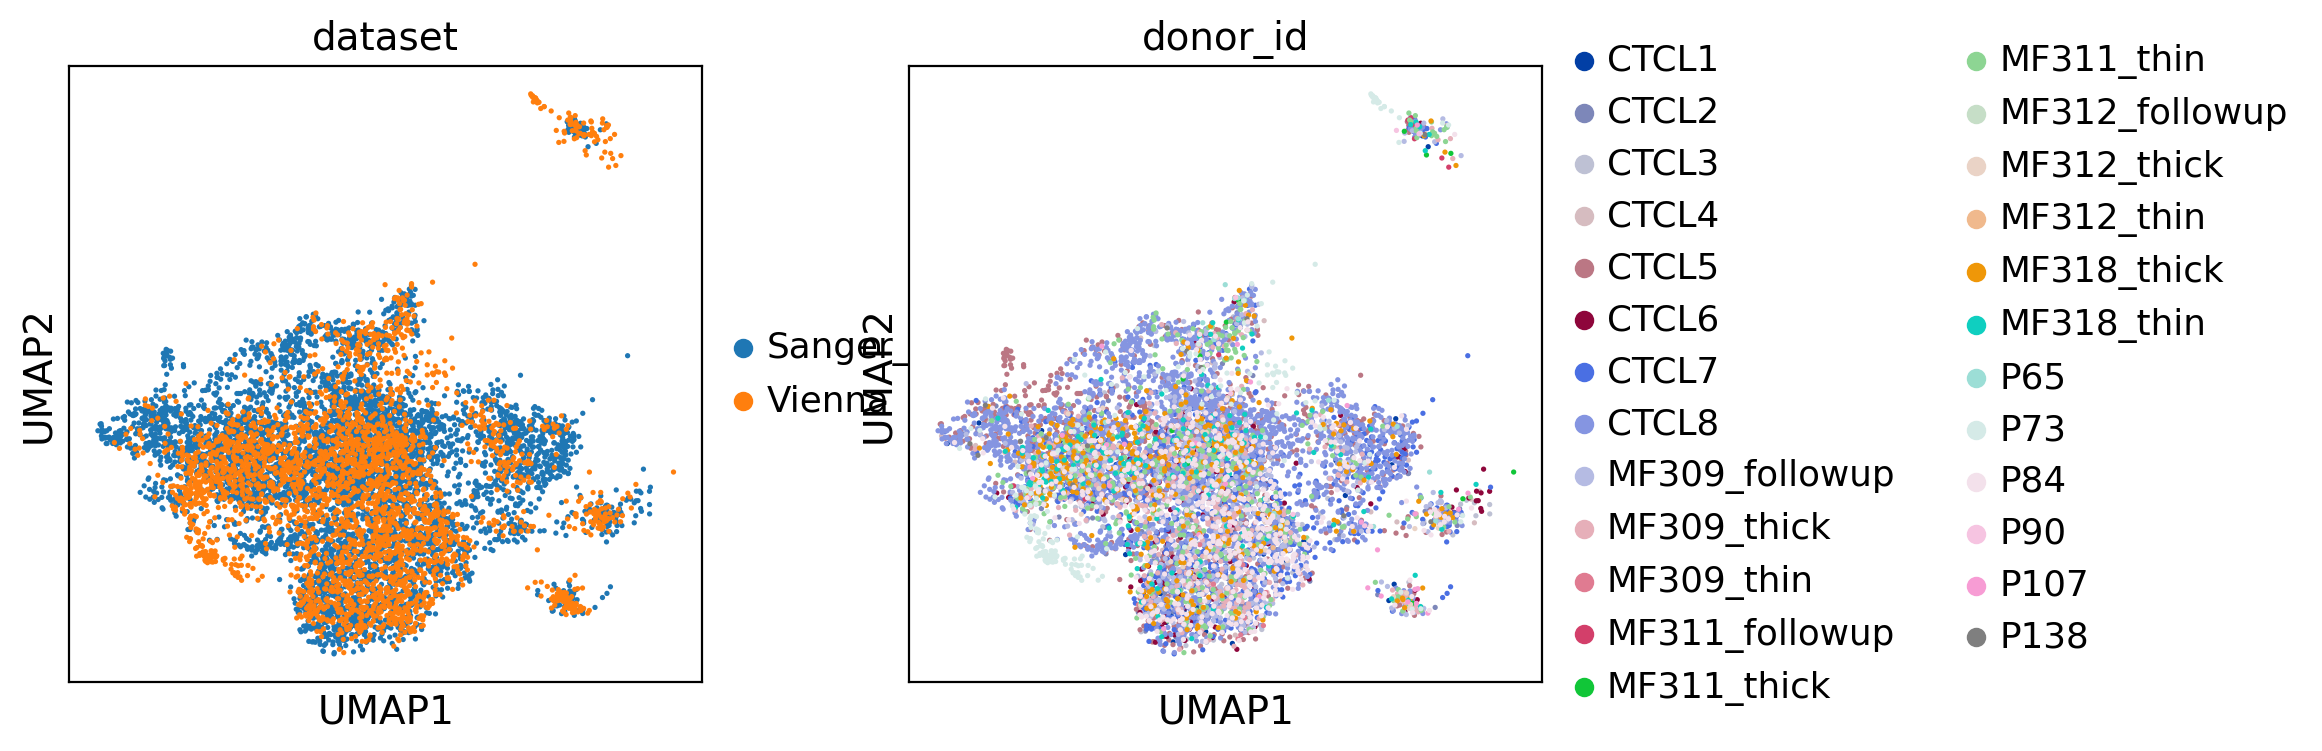

In [11]:
sc.settings.set_figure_params(dpi=100, facecolor='white')
sc.pl.umap(adata_filtered_harmony_sub, color=['dataset','donor_id'])